In [2]:
!pip3 install tensorflow-text==2.4.1

# import tensorflow as tf
# print(tf.__version__)

import tensorflow as tf
%tensorflow_version 2.x
# import tensorflow as tf
!pip3 install transformers
import os
import shutil
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.stats import spearmanr
from math import floor, ceil
import pickle
# import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Dropout, Activation, Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import shutil



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#---------Data Read & Transformation---------
#Data Reading for Davidson Dataset
nRowsRead = None # specify 'None' to read complete file
tweets_train = pd.read_csv('/TSA.csv')
tweets_train['label'].value_counts()
# sample = tweets_train.sample(n = 100, random_state = 155)
# sample['text'] = sample['tweet'].apply(lambda x: p.clean(x))
# nRow, nCol = df0.shape
# print(df0)
# print('There are {} rows and {} columns'.format(nRow, nCol))

#Doing Transformation
c=tweets_train['label']
tweets_train.rename(columns={'tweet' : 'text',
                   'label' : 'category'}, 
                    inplace=True)
a=tweets_train['text']
b=tweets_train['category'].map({0: 'neither', 1: 'hate'})
df= pd.concat([a,b,c], axis=1)
# df.rename(columns={'class' : 'label'}, 
#                     inplace=True)

neither,hate = np.bincount(df['label'])
total = hate + neither
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
# print('Examples:\n    Total: {}\n    Ofensive: {} ({:.2f}% of total)\n'.format(
#     total, ofensive, 100 * ofensive / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))

#Splitting Dataset
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.label.values,    
)

X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.loc[X_train_].label.values,  
)

df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

df_train = df.loc[df["data_type"]=="train"]
df_val = df.loc[df["data_type"]=="val"]
df_test = df.loc[df["data_type"]=="test"]

Examples:
    Total: 31962
    hate: 2242 (7.01% of total)

Examples:
    Total: 31962
    Neither: 29720 (92.99% of total)



In [4]:



#--------- Choosing Transfomer Model ---------
#creating tensors
train_ds = tf.data.Dataset.from_tensor_slices((df_train.text.values, df_train.label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.text.values, df_val.label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.text.values, df_test.label.values))

train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)

In [5]:
#Reading bert_en_uncased_L-2_H-128_A-2 in this file to fine tune

bert_model_name = 'electra_small'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

In [6]:
map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}


In [7]:
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

weight_for_0 = (1 / neither)*(total)/2.0 
# weight_for_1 = (1 / ofensive)*(total)/3.0
weight_for_1 = (1 / hate)*(total)/2.0

#defining classweight to give into the models
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
# print('Weight for class 2: {:.2f}'.format(weight_for_2))

BERT model selected           : https://tfhub.dev/google/electra_small/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
Weight for class 0: 0.54
Weight for class 1: 7.13


In [25]:
#Defining Model Architecture
def CNN_model():
    #Trasnformer Encoding before feeding to CNN
    text_in = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocess_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_in = preprocess_layer(text_in)
    encode = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encode(encoder_in)
    network_layer= sequence_output = outputs["sequence_output"]
    # 2 CNNLayers
    network_layer = tf.keras.layers.Conv1D(32, (2), activation='relu')(network_layer) #CNN Layer 1
    network_layer = tf.keras.layers.Conv1D(64, (2), activation='relu')(network_layer) #CNN Layer 2
    network_layer = tf.keras.layers.GlobalMaxPool1D()(network_layer) #Global Maxpooling Layer
    network_layer = tf.keras.layers.Dense(256, activation="relu")(network_layer) #DenseLayer 
    network_layer = tf.keras.layers.Dropout(0.1)(network_layer) #Dropout Layer
    network_layer = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(network_layer) #ClassificationLayer
    return tf.keras.Model(text_in, network_layer)

#building model
cnn_model = CNN_model()

In [26]:
#defining loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#importing latest tfmodel here to avoid package conflicts
!pip install tf-models-official
from official.nlp import optimization

#fine tuning and Training models
epochs_count = 20#defining_epochs_count
steps_each_epoch = tf.data.experimental.cardinality(train_ds).numpy()#steps_per_epoch
number_of_training_steps = steps_each_epoch * epochs_count#defining_Training_steps
number_of_warmup_steps = int(0.1*number_of_training_steps)#defining_warmup_steps
init_lr = 3e-5 #deifning learning rate

#creating_optimiser
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=number_of_training_steps,
                                          num_warmup_steps=number_of_warmup_steps,
                                          optimizer_type='adamw')
#model compiling
cnn_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))


print(f'Training model with {tfhub_handle_encoder}')
#training_model
cnn_history = cnn_model.fit(x=train_ds,
                            validation_data=val_ds,
                            epochs=epochs_count,
                            class_weight=class_weight)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Training model with https://tfhub.dev/google/electra_small/2
Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
809/809 [==============================] - ETA: 0s - loss: 0.9984 - accuracy: 0.2973

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
809/809 [==============================] - 283s 331ms/step - loss: 0.9981 - accuracy: 0.2976 - val_loss: 0.4141 - val_accuracy: 0.8370
Epoch 2/20
809/809 [==============================] - 266s 329ms/step - loss: 0.3980 - accuracy: 0.9050 - val_loss: 0.2180 - val_accuracy: 0.9253
Epoch 3/20
809/809 [==============================] - 266s 329ms/step - loss: 0.3215 - accuracy: 0.9529 - val_loss: 0.1824 - val_accuracy: 0.9409
Epoch 4/20
809/809 [==============================] - 266s 329ms/step - loss: 0.2585 - accuracy: 0.9729 - val_loss: 0.1198 - val_accuracy: 0.9639
Epoch 5/20
809/809 [==============================] - 267s 329ms/step - loss: 0.1969

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


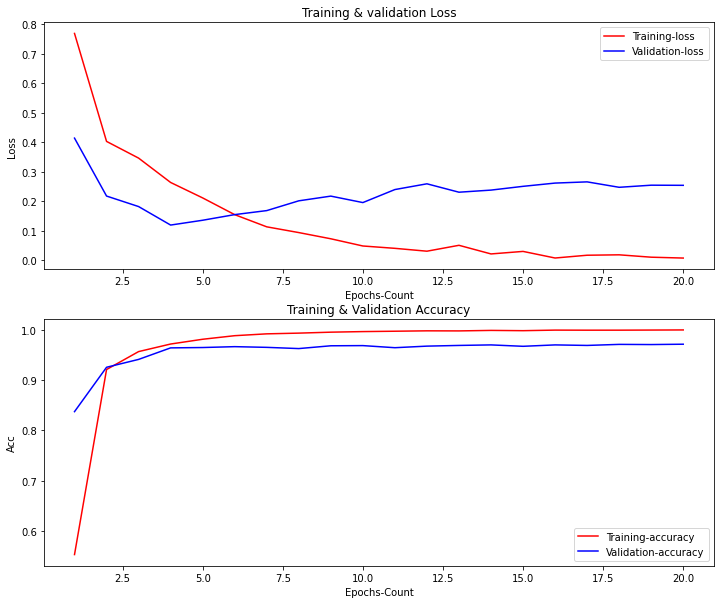

In [27]:
#creating graphs for accuracy and loss
#fining_values
history_dict = cnn_history.history
print(history_dict.keys())
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

#defining_figures
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()
#1st_figure
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training-loss')#training_loss
plt.plot(epochs, val_loss, 'b', label='Validation-loss')#validation_loss
plt.title('Training & validation Loss')
plt.xlabel('Epochs-Count')
plt.ylabel('Loss')
plt.legend()
#2nd_Figure
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training-accuracy')#training_accuracy
plt.plot(epochs, val_acc, 'b', label='Validation-accuracy')#validation_accuracy
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs-Count')
plt.ylabel('Acc')
plt.legend(loc='lower right')


In [28]:
#predicting on test dataset
text = []
test_labels = []
predictions = []
for text, label in test_ds.take(-1):
  text = text.numpy()#reading_text
  test_labels.append(label.numpy())#reading_text_label
  predictions.append(cnn_model.predict(text))#predicting

from itertools import chain
flatten_list = list(chain.from_iterable(predictions))

y_pred = np.argmax(flatten_list, axis=-1)#predicted_test_labels
y_test = np.array(list(chain.from_iterable(test_labels)))#true_test_labels

print(classification_report(y_test, y_pred))#priting_classfication_report
print(confusion_matrix(y_test, y_pred)) #priting_confusion_matrix


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2973
           1       0.82      0.76      0.79       224

    accuracy                           0.97      3197
   macro avg       0.90      0.88      0.89      3197
weighted avg       0.97      0.97      0.97      3197

[[2935   38]
 [  53  171]]


In [29]:
user_input = ["I cannot tolerate how these bitches conspire against each other", "You are welcome to come to my country","I hate black people"]
user_input_prediction = cnn_model.predict(user_input)

result = []
for values in user_input_prediction:
   max = -1
   type_comment = -1
   for index,value in enumerate(values): 
      if (value > max):
         max = value
         type_comment = index
   result.append(type_comment) 
for speech, output in zip(user_input, result):
   print(f'{speech[:100]} -> {output}')

I cannot tolerate how these bitches conspire against each other -> 0
You are welcome to come to my country -> 0
I hate black people -> 1


In [8]:
#building MLP archictecture
def create_MLP_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    #input layer    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    #preprocessing layer 
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    #giving input to bert model from the pre processed layer
    encoder_inputs = preprocessing_layer(text_input)
    #selecting the encoder
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    #collecting the output of the bert encoder
    outputs = encoder(encoder_inputs)
    #collecting the pooled outputs
    net = outputs['pooled_output']
    #feeding the output to the multilayer perception
    #1 DENSE LAYER
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    #1 DROPUT LAYER
    net = tf.keras.layers.Dropout(0.2)(net)
    #1 OUTPUT LAYER WITH SOFTMAX
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier', bias_initializer=output_bias)(net)
    return tf.keras.Model(text_input, net)

mlp_model = create_MLP_model()



In [9]:
#importing latest tfmodel here to avoid package conflicts
!pip install tf-models-official
from official.nlp import optimization

#fine tuning and Training models
epochs_count = 20 #defining_epochs_count
steps_each_epoch = tf.data.experimental.cardinality(train_ds).numpy() #steps_per_epoch
number_of_training_steps = steps_each_epoch * epochs_count #defining_Training_steps
number_of_warmup_steps = int(0.1*number_of_training_steps) #defining_warmup_steps
init_lr = 3e-5 #deifning learning rate

#creating_optimiser
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=number_of_training_steps,
                                          num_warmup_steps=number_of_warmup_steps,
                                          optimizer_type='adamw')
#model compiling
mlp_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))


print(f'Training model with {tfhub_handle_encoder}')
#training_model
mlp_history = mlp_model.fit(x=train_ds,
                            validation_data=val_ds,
                            epochs=epochs_count,
                            class_weight=class_weight)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 7.4 MB/s 
     |████████████████████████████████| 1.1 MB 36.5 MB/s 
     |████████████████████████████████| 99 kB 11.8 MB/s 
     |████████████████████████████████| 116 kB 62.2 MB/s 
     |████████████████████████████████| 238 kB 71.8 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 15.7 MB 44.9 MB/s 
     |████████████████████████████████| 636 kB 69.9 MB/s 
     |████████████████████████████████| 4.6 MB 45.6 MB/s 
     |████████████████████████████████| 352 kB 77.8 MB/s 
     |████████████████████████████████| 511.7 MB 6.4 kB/s 
     |████████████████████████████████| 1.3 MB 51.5 MB/s 
     |████████████████████████████████| 438 kB 73.2 MB/s 
     |████████████████████████████████| 1.6 MB 50.9 MB/s 
     |████████████████████████████████| 5.8 MB 56.9 MB/s 
     |███████████████████████████

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate 

Training model with https://tfhub.dev/google/electra_small/2
Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
809/809 [==============================] - ETA: 0s - loss: 0.8423 - accuracy: 0.8224

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
809/809 [==============================] - 279s 325ms/step - loss: 0.8421 - accuracy: 0.8224 - val_loss: 0.1639 - val_accuracy: 0.9444
Epoch 2/20
809/809 [==============================] - 260s 321ms/step - loss: 0.4200 - accuracy: 0.9072 - val_loss: 0.2778 - val_accuracy: 0.9079
Epoch 3/20
809/809 [==============================] - 260s 321ms/step - loss: 0.3348 - accuracy: 0.9542 - val_loss: 0.1526 - val_accuracy: 0.9527
Epoch 4/20
809/809 [==============================] - 260s 321ms/step - loss: 0.2532 - accuracy: 0.9734 - val_loss: 0.1361 - val_accuracy: 0.9652
Epoch 5/20
809/809 [==============================] - 261s 322ms/step - loss: 0.2167

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


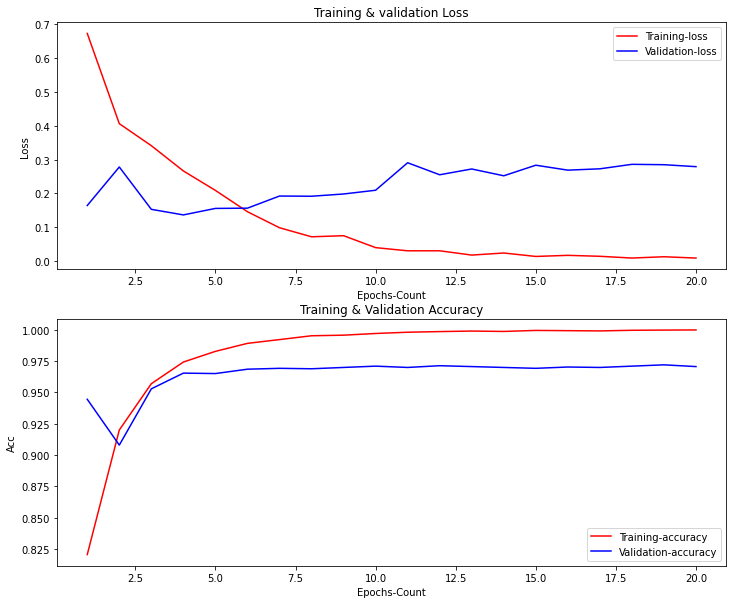

In [10]:
#creating graphs for accuracy and loss
#fining_values
history_dict = mlp_history.history
print(history_dict.keys())
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

#defining_figures
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()
#1st_figure
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training-loss')#training_loss
plt.plot(epochs, val_loss, 'b', label='Validation-loss')#validation_loss
plt.title('Training & validation Loss')
plt.xlabel('Epochs-Count')
plt.ylabel('Loss')
plt.legend()
#2nd_Figure
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training-accuracy')#training_accuracy
plt.plot(epochs, val_acc, 'b', label='Validation-accuracy')#validation_accuracy
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs-Count')
plt.ylabel('Acc')
plt.legend(loc='lower right')

In [11]:

#predicting
text = []
test_label = []
predictions = []

for text, label in test_ds.take(-1):
  text = text.numpy()#reading_text
  test_label.append(label.numpy())#reading_text_label
  predictions.append(mlp_model.predict(text))#predicting

from itertools import chain
flatten_list = list(chain.from_iterable(predictions))

y_pred = np.argmax(flatten_list, axis=-1)
y_test = np.array(list(chain.from_iterable(test_label)))

print(classification_report(y_test, y_pred))#priting_classfication_report
print(confusion_matrix(y_test, y_pred)) #priting_confusion_matrix

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2973
           1       0.81      0.75      0.77       224

    accuracy                           0.97      3197
   macro avg       0.89      0.87      0.88      3197
weighted avg       0.97      0.97      0.97      3197

[[2933   40]
 [  57  167]]


In [12]:
def MLP_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    #input layer    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    #preprocessing layer 
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    #giving input to bert model from the pre processed layer
    encoder_inputs = preprocessing_layer(text_input)
    #selecting the encoder
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    #collecting the output of the bert encoder
    outputs = encoder(encoder_inputs)
    #collecting the pooled outputs
    net = outputs['pooled_output']
    #feeding the output to the multilayer perception
    #1 DENSE LAYER
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    #1 DROPUT LAYER
    net = tf.keras.layers.Dropout(0.2)(net)
    #1 OUTPUT LAYER WITH SOFTMAX
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier', bias_initializer=output_bias)(net)
    return tf.keras.Model(text_input, net)

In [13]:
#Defining Model Architecture
def CNN_model():
    #Trasnformer Encoding before feeding to CNN
    text_in = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocess_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_in = preprocess_layer(text_in)
    encode = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encode(encoder_in)
    network_layer= sequence_output = outputs["sequence_output"]
    # 2 CNNLayers
    network_layer = tf.keras.layers.Conv1D(32, (2), activation='relu')(network_layer) #CNN Layer 1
    network_layer = tf.keras.layers.Conv1D(64, (2), activation='relu')(network_layer) #CNN Layer 2
    network_layer = tf.keras.layers.GlobalMaxPool1D()(network_layer) #Global Maxpooling Layer
    network_layer = tf.keras.layers.Dense(256, activation="relu")(network_layer) #DenseLayer 
    network_layer = tf.keras.layers.Dropout(0.1)(network_layer) #Dropout Layer
    network_layer = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(network_layer) #ClassificationLayer
    return tf.keras.Model(text_input, network_layer)



In [14]:
user_input = ["I dislike all the people who do not come in time to office", "You are welcome to come to my country","I hate black people"]
user_input_prediction = mlp_model.predict(user_input)

result = []
for values in user_input_prediction:
   max = -1
   type_comment = -1
   for index,value in enumerate(values): 
      if (value > max):
         max = value
         type_comment = index
   result.append(type_comment) 
for speech, output in zip(user_input, result):
   print(f'{speech[:100]} -> {output}')

I dislike all the people who do not come in time to office -> 0
You are welcome to come to my country -> 0
I hate black people -> 1


Note: Used some slang languages as part of custom inputs to test the hate speech performance.